# $\S$7.2 Exploring the data - telling a story

This notebook will explore and visualize some of the data from retrosheet.org for Major League Baseball during the 2010-2018 seasons.

From **https://www.retrosheet.org/notice.txt**
<pre>
Recipients of Retrosheet data are free to make any desired use of
the information, including (but not limited to) selling it,
giving it away, or producing a commercial product based upon the
data.  Retrosheet has one requirement for any such transfer of
data or product development, which is that the following
statement must appear prominently:

     The information used here was obtained free of
     charge from and is copyrighted by Retrosheet.  Interested
     parties may contact Retrosheet at "www.retrosheet.org".

Retrosheet makes no guarantees of accuracy for the information 
that is supplied. Much effort is expended to make our website 
as correct as possible, but Retrosheet shall not be held 
responsible for any consequences arising from the use the 
material presented here. All information is subject to corrections 
as additional data are received. We are grateful to anyone who
discovers discrepancies and we appreciate learning of the details.
</pre>

The data used here was previously put together in the project for $\S$5.4 into a `.pickle` file. This file is loaded below.

## Loading packages to be used

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import itertools as itr
import collections as coll
import re
import os
import subprocess
import pickle
import datetime as dt

## Loading the data fram from the pickle file

Here the base directory is created. This will allow for sub-directories for the retrosheet data and the resulting processed data to be stored.

In [2]:
basedir = os.getcwd()
#print(basedir)

In [3]:
%%time
os.chdir(basedir)
os.chdir('data')

data = pd.read_pickle('retro_mlb_dataframe.pickle')

Wall time: 1.77 s


## Describing the data generally.

In [4]:
data.shape

(1717976, 51)

Between 2010 and 2018 there were 1717976 events in baseball games. There are 51 columns of information here as described using the `info()` method.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1717976 entries, 0 to 1717975
Data columns (total 51 columns):
gameid              object
awayteam            category
inning              int64
teamatbat           category
outs                int64
balls               int64
strikes             int64
pitches             object
scoreaway           int64
scorehome           int64
batter              object
batterhand          category
resbatter           object
resbatterhand       category
pitcher             object
pitcherhand         category
respitcher          object
respitcherhand      category
runner01            object
runner02            object
runner03            object
eventtext           object
leadoffflag         bool
pinchhitflag        bool
batterpos           category
lineupposition      category
eventtype           object
plateappoverflag    bool
abflag              bool
hitvalue            int64
SHflag              bool
SFflag              bool
outsresult          int64


### Adding columns to the dataframe.

Some information that we can derive from the dataframe are the date, whether the home team wins and pitch sequences. Adding the date information first allows for more easily accessing sections of the dataframe according to the datetime information.

$\circ$ **date**

This information will be extracted from the `gameid` column.

In [6]:
data['date'] = pd.to_datetime( data.gameid.str.slice(start=3,stop=-1), format='%Y%m%d')
data.date.unique().size

1622

### Other columns to add:

> `hometeam`<br>
> `runsonplay`<br>
> `endscore_home` and `endscore_away`<br>
> `endscore_diff`<br>
> `homewin` <br>

$\circ$ **hometeam**

<code>hometeam</code> will be the three letter designation of the hometeam<br>                                      

In [7]:
data['hometeam'] = data.gameid.str.slice(stop=3)

$\circ$ **runsonplay**

`runsonplay` is the number of runs scored on a given play.

This is calculated by adding together the number of runners (including batter) that make it to home plate.

In [8]:
data['runsonplay'] = (data.destbatter>3)*1 + (data.dest01>3)*1 + (data.dest02>3)*1 + (data.dest03>3)*1
data.runsonplay.value_counts()

0    1569201
1     115749
2      26081
3       5939
4       1006
Name: runsonplay, dtype: int64

$\circ$ **Score at end of the play**

<code>endscore_home</code> will be <code>scorehome + runsonplay</code> if <code>teamatbat==1</code><br>
<code>endscore_away</code> will be <code>scoreaway + runsonplay</code> if <code>teamatbat==0</code><br>

<code>scorediff_end</code> will be equal to <code>endscore_home - endscore_away</code> (i.e. diff at end of play)<br>

In [9]:
data['endscore_away'] = (data.teamatbat == 0) * (data.runsonplay) + data.scoreaway
data['endscore_home'] = (data.teamatbat == 1) * (data.runsonplay) + data.scorehome

data['endscore_diff'] = data.endscore_home - data.endscore_away

$\circ$ **Number of wins by the home team.**

<code>homewin</code> will be **boolean** T/F where `endscore_home > endscore_away` i.e. T = homewin                                       

In [10]:
data['homewin'] = data.endscore_home > data.endscore_away

## How is the difference in scores at the end of each game distributed?

In [11]:
data[data.endgame==True].endscore_diff.abs().value_counts()

1     6383
2     4031
3     3096
4     2557
5     1809
6     1343
7      898
8      621
9      404
10     277
11     179
12     101
13      73
14      35
15      22
16      20
17       7
18       6
19       2
20       2
21       1
0        1
Name: endscore_diff, dtype: int64

As expected, there are very few ties (we actually would expect zero). The exception can be identified quickly which was a game between Pittsburg and Cincinatti on 2016-09-29.

In [12]:
data[(data.endgame==True) & 
     (data.endscore_diff==0)].loc[:,['date','hometeam','awayteam','scorehome','scoreaway',
                                       'endscore_home','endscore_away',
                                       'inning','teamatbat', 'rbiresult']].sort_values(by='date')

,date,hometeam,awayteam,scorehome,scoreaway,endscore_home,endscore_away,inning,teamatbat,rbiresult
1284931,2016-09-29,PIT,CHN,1,1,1,1,6,0,0


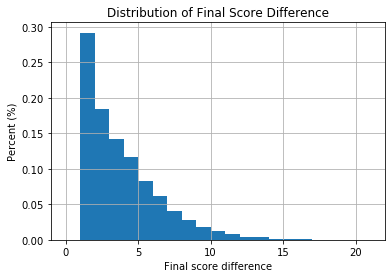

In [13]:
data[data.endgame==True].endscore_diff.abs().hist(bins=range(22),density=True)
plt.xlabel('Final score difference')
plt.ylabel('Percent (%)')
plt.title('Distribution of Final Score Difference');

This appears to be a distribution that could be either exponential in nature or possibly a Poisson distribution.

## How many games were played by year?

### The number of games by year.

In [14]:
data[data.endgame==True].groupby(data.date.dt.year).date.count()

date
2010    2430
2011    2429
2012    2430
2013    2431
2014    2430
2015    2429
2016    2428
2017    2430
2018    2431
Name: date, dtype: int64

**Comment:** The total each year should be $81\times30=2430$ so there is some discrepancy here.

The discrepancy is accounted for when we look back and see when extra games were played (i.e. to determine a wildcard team) or when a game is cancelled and not made up (i.e. because of weather).


2010: No extra games</br>
2011: cancelled: Washington Nationals v. LA Dodgers<br>
2012: None<br>
2013: Extra game: Tampa v. Texas Rangers<br>
2014: None<br>
2015: cancelled: Cleveland v. Detroit<br>
2016: cancelled: Miami v. Braves, Cleveland v. Detroit. ended in tie: Cubs v. Pirates (net -2)<br>
2017: None<br>
2018: cancelled: Miami v. Pirates, two extra games involving Brewers, Cubs, Dodgers and Rockies (net +1)

### Q. How many games were played by month each year?

3=Mar, 4=April etc.

In [15]:
data[data.endgame==True].groupby([data.date.dt.year, data.date.dt.month]).date.count().unstack().fillna(0).astype('int64')

date,3,4,5,6,7,8,9,10
date,,,,,,,,
2010,0,345,424,401,388,422,404,46
2011,6,392,420,400,395,420,396,0
2012,2,336,425,404,383,425,410,45
2013,1,392,418,407,386,421,406,0
2014,16,389,424,409,381,423,388,0
2015,0,327,428,407,377,420,413,57
2016,0,354,424,407,381,424,408,30
2017,0,369,421,408,376,425,416,15
2018,38,381,416,401,373,414,406,2


There are fewer games in March and October as they mark the beginning and end of the seasons. 

In July there are typically fewer games because of the All-Star break.

### Q. And how many home games were played each year by league?

Here we are counting by league according to which league the hometeam is in (contained in `data.league`).

In [16]:
data[data.endgame==True].groupby([data.date.dt.year,data.league]).size().unstack()

league,eva,evn
date,,
2010,1134,1296
2011,1134,1295
2012,1134,1296
2013,1216,1215
2014,1215,1215
2015,1214,1215
2016,1214,1214
2017,1215,1215
2018,1215,1216


Aside from 2010-2012, the number of games per league is dividely fairly evenly. There is a discrepancy in the earlier years because of interleague play. In those years, there were 16 National League teams and only 14 American League teams which created the disparity (as a result the NL teams had more home games).

In 2013, the Houston Astros switched from NL to AL (into the AL Central) balancing out the number of teams in each league.

### Q. When were more short and long games played?

**Short games:** Number of games ending early (before 9 innings) by month and year.

In [17]:
data[(data.endgame==True) 
     & (data.inning < 9)
    ].groupby([data.date.dt.year, data.date.dt.month]).date.count().unstack().fillna(0).astype('int64')

date,4,5,6,7,8,9,10
date,,,,,,,
2010,2,1,1,1,1,0,1
2011,1,3,1,0,1,1,0
2012,1,0,0,3,2,1,0
2013,2,0,1,1,2,2,0
2014,0,0,1,2,1,0,0
2015,1,2,1,0,0,0,0
2016,1,0,0,1,1,4,0
2017,0,0,0,1,0,1,0
2018,0,0,0,1,1,3,0


There does not seem to be any special pattern to when more or less short games are played. This is not a surprise since these are typically caused by weather which is a random event.

**Long games:** Number of extra inning games (longer than 9 innings) by month and year and league.

In [18]:
data[(data.endgame==True) 
     & (data.inning > 9)
    ].groupby([data.date.dt.year, data.league, data.date.dt.month]).date.count().unstack().unstack().fillna(0).astype('int64')

date    3       4       5       6       7       8       9       10    
league eva evn eva evn eva evn eva evn eva evn eva evn eva evn eva evn
date                                                                  
2010     0   0  15  18  16  19   8  22  21  23  18  21  20  11   4   4
2011     0   1  22  24  27  21  14  24   8  20  16  21  14  25   0   0
2012     1   0  13  16  11  19  15  12  13  21  18  13  17  18   3   2
2013     0   0  17  20  22  23  21  27  17  20  19  21  18  18   0   0
2014     0   2  17  23  20  24  16  19  16  16  23  26  17  13   0   0
2015     0   0  13  16  14  19  14  21  19  16  25  18  18  17   1   1
2016     0   0  11  16  14  15  18  16  15  15  13  21  11  16   2   2
2017     0   0  18  18  14  23  12  17  20  14  10  10  13  13   0   0
2018     3   4  16  20  20  14  15  17  18  24  11  23  12  19   0   0

It seems that there might be more games going into extra innings when games are hosted by National League teams.

**Long games by league:** Extra inning by league (i.e. determined by home field) and year.

Here we only look at 2013 and after since during these seasons the number of games per league was approximately the same in each of these years.

In [19]:
data[(data.endgame == True) & (data.inning > 9) & (data.date > '2013')].groupby([data.date.dt.year, data.league]).date.count().unstack()

league,eva,evn
date,,
2013,114,129
2014,109,123
2015,104,108
2016,84,101
2017,87,95
2018,95,121


## How the types of hits are distributed.

### The number and types of hits.

1 = single, 2 = double, 3 = triple and 4 = homerun.

In [20]:
data.hitvalue.value_counts().sort_index()

0    1339788
1     250604
2      74663
3       7766
4      45155
Name: hitvalue, dtype: int64

In [21]:
data.hitvalue.value_counts().sort_index()/data.hitvalue.value_counts().sum()

0    0.779864
1    0.145872
2    0.043460
3    0.004520
4    0.026284
Name: hitvalue, dtype: float64

Triples are easily the most rare of the hits. Doubles happen about 1.5 times as many times as home runs. Singles happen a little more than three times as much as doubles or about five times as often as home runs.

### Types of hits by league. Comparing after 2012 season.

In [22]:
data[data.date > '2012-12'].groupby('league').hitvalue.value_counts().unstack()

hitvalue,0,1,2,3,4
league,,,,,
eva,444560,82983,25050,2310,16365
evn,447639,82673,24467,2765,14691


The seasons 2010-2012 are removed as there are more home games for the NL during those years.

In the other years, it appears that singles and double appear to be about the same. There do appear to be more triples in NL games and more home runs in AL games.

### Q. How many runs are scored per hit?

In [23]:
data[data.hitvalue>0].groupby(['runsonplay']).hitvalue.value_counts().unstack().fillna(0).astype('int64')

hitvalue,1,2,3,4
runsonplay,,,,
0,203882,51169,4338,0
1,40339,17246,2227,26477
2,6325,5525,958,12775
3,56,722,240,4903
4,2,1,3,1000


## Percentage of overall games where the home team wins.

The home winning percentage during 2010-2018.

In [24]:
data[data.endgame==True].homewin.mean()

0.5359886592280958

The home winning percentage by year and league.

In [25]:
data[data.endgame==True].groupby([data.date.dt.year, 'league']).homewin.mean().unstack()

league,eva,evn
date,,
2010,0.557319,0.560185
2011,0.533510,0.518147
2012,0.533510,0.532407
2013,0.532895,0.542387
2014,0.519342,0.540741
2015,0.543657,0.539918
2016,0.544481,0.515651
2017,0.537449,0.541564
2018,0.530041,0.525493


For the most part there does not seem to be any big disparity between the home winning percentage in each league. There does however appear to be an obvious home field advantage since the percentages are consistently above 50% for both leagues in every year.

## What different events occurred with each plate appearance?

from **https://www.retrosheet.org/datause.txt**
<pre>
event type.  There are 25 different numeric codes to describe
             the type of event.  They are:

          Code Meaning

          0    Unknown event
          1    No event
          2    Generic out
          3    Strikeout
          4    Stolen base
          5    Defensive indifference
          6    Caught stealing
          7    Pickoff error
          8    Pickoff
          9    Wild pitch
          10   Passed ball
          11   Balk
          12   Other advance
          13   Foul error
          14   Walk
          15   Intentional walk
          16   Hit by pitch
          17   Interference
          18   Error
          19   Fielder's choice
          20   Single
          21   Double
          22   Triple
          23   Home run
          24   Missing play
</pre>

In [26]:
eventdict = {0:'unknown',1:'none',2:'out',3:'K',4:'SB',
            5:'defensive indiff', 6:'caught stealing', 7:'pickoff error', 8:'pickoff', 9:'WP',
            10:'passed ball', 11:'balk', 12:'other advance', 13:'foul error', 14:'BB',
            15:'intential BB', 16:'HBP', 17:'interference', 18:'Error', 19:'Fielders Choice',
            20:'Single', 21:'Double', 22:'Triple', 23:'Home Run', 24:'Missing play'
           }

Using this mapping, a new column `eventtypestr` is created.

In [27]:
data['eventtypestr']=data.eventtype.map(eventdict).astype('category')
data.eventtypestr.dtype

CategoricalDtype(categories=['BB', 'Double', 'Error', 'Fielders Choice', 'HBP',
                  'Home Run', 'K', 'SB', 'Single', 'Triple', 'WP', 'balk',
                  'caught stealing', 'defensive indiff', 'foul error',
                  'intential BB', 'interference', 'other advance', 'out',
                  'passed ball', 'pickoff'],
                 ordered=False)

In [28]:
data.eventtypestr.value_counts().sort_values()

interference           284
foul error             378
other advance          958
balk                  1367
defensive indiff      2721
passed ball           2760
Fielders Choice       4608
pickoff               4815
caught stealing       6583
Triple                7766
intential BB          9287
WP                   14019
Error                14118
HBP                  14723
SB                   21954
Home Run             45155
Double               74663
BB                  125554
Single              250604
K                   337110
out                 778549
Name: eventtypestr, dtype: int64

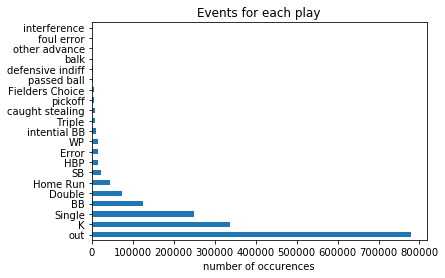

In [29]:
data.eventtypestr.value_counts().plot.barh()
plt.xlabel('number of occurences')
plt.title('Events for each play');

### Which events result in runs?

In [30]:
data.groupby('eventtypestr').runsonplay.value_counts().unstack().fillna(0).astype('int64')

runsonplay,0,1,2,3,4
eventtypestr,,,,,
BB,122937,2616,1,0,0
Double,51169,17246,5525,722,1
Error,11683,2106,315,14,0
Fielders Choice,3775,793,39,1,0
HBP,14337,386,0,0,0
Home Run,0,26477,12775,4903,1000
K,336921,182,7,0,0
SB,21586,362,6,0,0
Single,203882,40339,6325,56,2


## Pitcher hand v. Batter hand. Does it make a difference?

### How many runs scored depending on handedness of batter and pitcher.

In [31]:
data.groupby(['batterhand','pitcherhand','runsonplay']).size().unstack()

runsonplay                   0      1      2     3    4
batterhand pitcherhand                                 
L          L            125791   8889   2018   443   64
           R            543128  39475   8866  1938  346
R          L            304665  22060   5056  1176  201
           R            595617  45325  10141  2382  395

In American League?

In [32]:
data[data.league=='eva'].groupby(['batterhand', 'pitcherhand', 'runsonplay']).size().unstack()

runsonplay                   0      1     2     3    4
batterhand pitcherhand                                
L          L             63994   4655  1031   225   35
           R            271404  20017  4579   992  187
R          L            154275  11354  2625   611   96
           R            276074  21543  4891  1182  190

In National League?

In [33]:
data[data.league=='evn'].groupby(['batterhand', 'pitcherhand', 'runsonplay']).size().unstack()

runsonplay                   0      1     2     3    4
batterhand pitcherhand                                
L          L             61797   4234   987   218   29
           R            271724  19458  4287   946  159
R          L            150390  10706  2431   565  105
           R            319543  23782  5250  1200  205

## Who walks and when?

In [34]:
data[data.eventtext=='W'].groupby(data.date.dt.year)['eventtext'].value_counts().unstack()

eventtext,W
date,
2010,10485
2011,10143
2012,10019
2013,9849
2014,9522
2015,9556
2016,10212
2017,10768
2018,10630


### Does the home or away team walk more?

In [35]:
data[data.eventtext=='W'].groupby(['inning','teamatbat'])['eventtext'].value_counts().unstack().unstack()

eventtext     W      
teamatbat     0     1
inning               
1          5195  6016
2          4705  4920
3          4821  5131
4          4764  5191
5          4861  4992
6          4655  5267
7          4955  5432
8          5024  5413
9          4876  2852
10          496   460
11          295   247
12          138   146
13           68    85
14           43    44
15           23    18
16           12    13
17            4     6
18            5     5
19            3     3

It seems like there may be a difference between the home and away teams. The home team appears to walk a bit more frequently. This discrepancy does not appear as dominant or it disappears in the later innnings (9th inning and later).

This can be partly explained by the home team not needing their full at bats if they win or are leading in any of the innings after the 8th inning.

## How are the pitch sequences distributed?

In [36]:
data.pitches # Pandas series

0            CSBFFBFC
1                  FX
2                 CBX
3          BBCCFBFFFB
4                  CX
              ...    
1717971          FFBX
1717972        .BBFBB
1717973          .SFS
1717974          CSFX
1717975           BBX
Name: pitches, Length: 1717976, dtype: object

In [37]:
print(re.escape('+*.123>'))
regex_nonpitch = re.compile('['+re.escape('+*.123>')+']')

\+\*\.123>


In [38]:
# balls: B ball, H hit batter, I intentional ball, N no pitch, P pitchout, U unknown, V called ball
regex_ball = re.compile('[BHINPUV]')

# strikes: all others i.e
# C called strike, F foul, K strike, L foul bunt, M missed bunt, O foul tip bunt, Q swing on pitchout
# R foul on pitchout, S swinging strike, T foul tip, X ball in play by batter, Y ball in play on pitchout
regex_strike = re.compile('[CFKLM]')

In [39]:
data['pitchesonly'] = data.pitches.str.replace(regex_nonpitch,'') #removes all non-pitches with 
data['pitchcount'] = data.pitchesonly.str.len()

In [40]:
pitchcounts = pd.Series(data.pitchcount.value_counts(),index=range(22)).fillna(0).astype('int64')
pitchcounts

0       1277
1     199246
2     277601
3     312043
4     326906
5     280194
6     188444
7      80538
8      32343
9      12201
10      4598
11      1648
12       607
13       200
14        81
15        22
16         8
17         3
18         1
19         0
20         0
21         1
Name: pitchcount, dtype: int64

In [41]:
xbar_pitches = data.pitchcount.mean()
s_pitches = data.pitchcount.std()
print('Mean # of pitches: {:0.3f}'.format(xbar_pitches))
print('Std. dev of # of pitches: {:0.3f}'.format(s_pitches))
print('95% C.I. of # of pitches: ({:0.3f}, {:0.3f})'.format(xbar_pitches - 2*s_pitches, xbar_pitches + 2*s_pitches))
print(data.pitchcount.quantile([0.1, 0.25, 0.5, 0.75, 0.9]))
print(data.pitchcount.std())

Mean # of pitches: 3.806
Std. dev of # of pitches: 1.879
95% C.I. of # of pitches: (0.047, 7.564)
0.10    1.0
0.25    2.0
0.50    4.0
0.75    5.0
0.90    6.0
Name: pitchcount, dtype: float64
1.8791867289099837


In [42]:
print('more than 7 pitches: {:0.4f}'.format(data[data.pitchcount > 7].pitchcount.sum()/data.pitchcount.sum()))
print('more than 8 ptiches: {:0.4f}'.format(data[data.pitchcount > 8].pitchcount.sum()/data.pitchcount.sum()))

more than 7 pitches: 0.0679
more than 8 ptiches: 0.0284


So more than 8 pitches in this case would be considered an outlier.

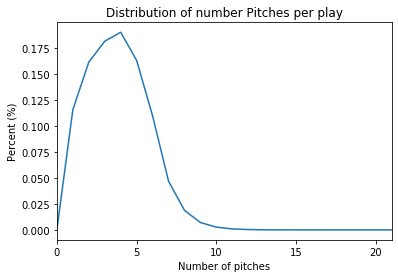

In [43]:
(pitchcounts/pitchcounts.sum()).plot()
plt.xlabel('Number of pitches')
plt.ylabel('Percent (%)')
plt.xticks([0,5,10,15,20])
plt.title('Distribution of number Pitches per play');

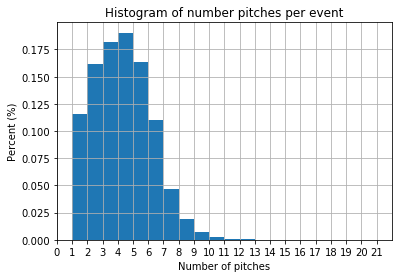

In [45]:
data.pitchcount.hist(bins=list(range(1,22)), density=True);
plt.xticks(list(range(22)))
plt.title('Histogram of number pitches per event')
plt.xlabel('Number of pitches')
plt.ylabel('Percent (%)');